<IPython.core.display.Javascript object>


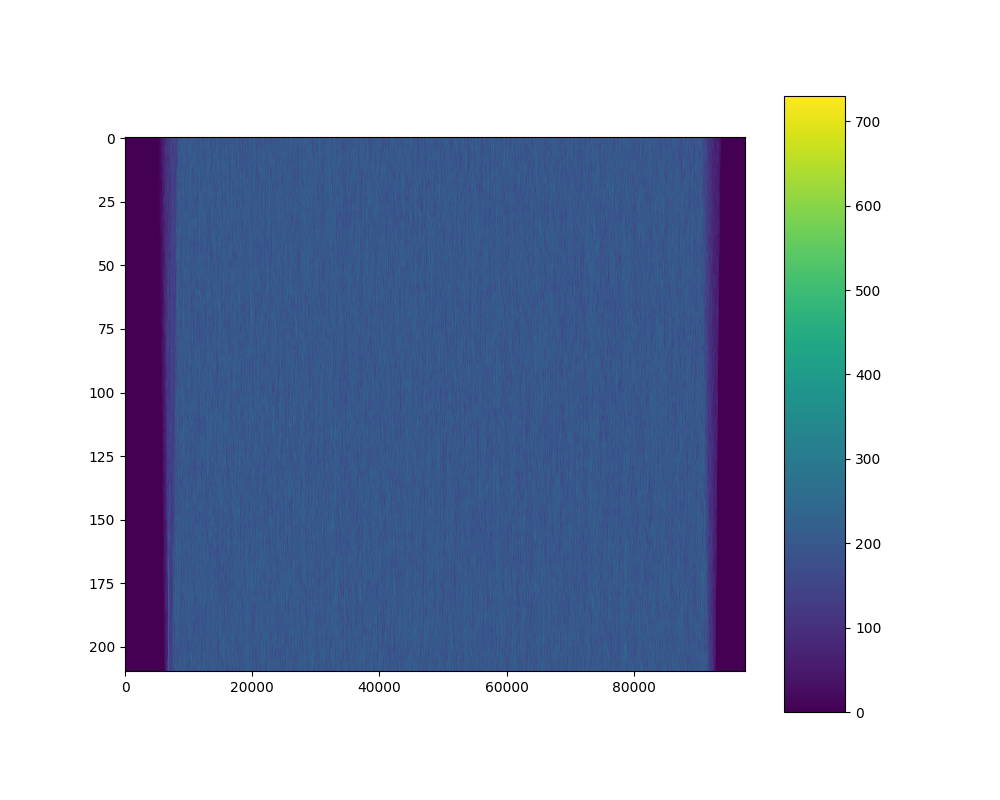

In [13]:
import tensorflow as tf
import numpy
import scipy.io
from tensorflow.python.client import timeline
import time

sessione = tf.Session()

# CARICO DATI

tFft = 8192#4096#8192
tObs = 9 #mesi
tObs = tObs*30*24*60*60
nPunti = 10
cands = 10

#percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi52HWI.mat"
#percorsoQuad = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI52.mat"
#percorsoPatch = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI52Ecl.mat"

#percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi108HWI.mat"
#percorsoQuad = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI108.mat"
#percorsoPatch = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI108Ecl.mat"


percorsoDati = "/home/protoss/Documenti/TESI/DATI/dati9mesi108HWI.mat"
percorsoQuad = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI108.mat"
percorsoPatch = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/quadHWI108Ecl.mat"




#carico file dati
quadrato = scipy.io.loadmat(percorsoQuad)['quad']
patch = scipy.io.loadmat(percorsoPatch)['quadratoEclNew']
struttura = scipy.io.loadmat(percorsoDati)['job_pack_0']
tempi = struttura['peaks'][0,0][0]
frequenze = struttura['peaks'][0,0][1]
pesi = (struttura['peaks'][0,0][4]+1)



#nb: picchi ha 0-tempi
#              1-frequenze
#              2-pesi

#headers vari
#securbelt = 4000
securbelt = 4000*3

#frequenze
stepFreq = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFreq/enhancement
nstepsFreq = securbelt+(numpy.amax(frequenze)-numpy.amin(frequenze) + stepFreq + 2*stepFreqRaffinato)/stepFreqRaffinato

#tempi
#epoca definita come mediana di tempi di tutto il run #WARNING da ridefinire con durata dati che prendo
epoca = struttura['basic_info'][0,0]['epoch'][0,0]
#epoca = (57722+57874)/2

#spindowns
spindownMin = -1e-9
spindownMax = 1e-10
stepSpindown = stepFreq/tObs 

nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)

indice0 = numpy.where(spindowns>0)[0][0]-1
spindowns = spindowns-spindowns[indice0]

veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:]
nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
indices = struttura['basic_info'][0,0]['index'][0,0][0]


# calcola la hough per ogni punto del cielo (per ogni spindown)
def inDaHough():
    def houghizza(stepIesimo):
        sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiHM, name = "Tdotpert")
        #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
        appoggio = tf.round(freqHM-sdTimed+securbelt/2, name = "appoggioperindici")
        appoggio = tf.cast(appoggio[0], dtype=tf.int32)
        
        
        valorisx = tf.unsorted_segment_sum(pesiHM, appoggio, nColumns)
        return valorisx
    
    freq = freqTF
    freqHM = freq[1:tf.size(freq)]
    freqIn = freq[0]
    
    # faccio la hough (differenziale)
    houghDiff = tf.map_fn(houghizza, tf.range(0, nRows), dtype=tf.float32, parallel_iterations=8)

    def sliceInt():
        #faccio integrazione finale (vecchia versione senza conv)
        semiLarghezza = tf.round(enhancement/2+0.001)
        semiLarghezza = tf.cast(semiLarghezza, tf.int32)
        houghInt = houghDiff[:,enhancement:nColumns]-houghDiff[:,0:nColumns - enhancement]
        houghInt = tf.concat([houghDiff[:,0:enhancement],houghInt],1)
        return houghInt
    
    hough = sliceInt()
    houghinal = tf.cumsum(hough, axis = 1)
    
    return houghinal, freqIn
    #return houghDiff
    
    


tempiTF = tf.constant(tempi, dtype=tf.float64)


velTF = tf.constant(veloc, dtype=tf.float64)
quadTF = tf.constant(quadrato, dtype=tf.float64)

pesiTF = tf.constant(pesi,dtype=tf.float32)

spindownsTF = tf.constant(spindowns, dtype=tf.float32) 
#nPunti = tf.constant(numpy.shape(quadrato)[0], dtype=tf.int32)

#nPunti = tf.constant(numpy.shape(quadrato)[0], dtype=tf.int32)
def doppCorr():
    freqTF = tf.constant(frequenze, dtype=tf.float64)
    
    
    tempiDC = tempiTF - primoTempo
    #tempiDC = tempiTF - tf.reduce_min(tempiTF)
    
    tempiUnici, indiciUniciRipetuti, conteggi = tf.unique_with_counts(tempiDC)

    indiciUnici = tf.cumsum(tf.pad(tf.unique_with_counts(indiciUniciRipetuti)[2],[[1,0]]))[:-1]
    nIndici = tf.size(tempiUnici)
    differenze = tempiUnici[1:]-tempiUnici[:-1]


    stepTempi = tf.reduce_min(differenze)
    # il primo elemento nella peakmap è a tempi successivi del primo elemento delle velocità
    tempiPrima = tf.reduce_min(tempiUnici)/stepTempi
    tempiPrima = tf.cast(tempiPrima, dtype=tf.int64)
    # vedo dove sono i salti
    stepSaltati = differenze/stepTempi
    stepSaltati = tf.cast(stepSaltati, dtype=tf.int64)

    # ora seleziono solo gli indici dell'array di velocità
    # ai quali il relativo step temporale ha frequenze non nulle nella peakmap

    indiciVel = tf.zeros([tf.size(tempiUnici)-1],dtype=tf.int64) + tempiPrima
    indiciVel = indiciVel + tf.cumsum(stepSaltati)
    indiciVel = tf.concat([[tempiPrima], indiciVel],0)
    # qui va messa parte per calcolare i pesi, che per ora non mettiamo
    #def doppcorr(i):
        #qui faccio la doppl corr
    velPerPos = tf.matmul(tf.reshape(quadTF[0], [1,3]),velTF)
    velPerPos = velPerPos
    velPerPos = velPerPos[0]
    #nel programma originale c'è un prodotto elementwise infattibile
    #(tra due array di diversa dimensione)
    # c'è anche un for che considera buchi di tempi dentro e prima

    #qui cerco tutti i salti temporali vedendo quando tra un elemento e l'altro 
    #c'è una differenza maggiore (un multiplo) dello step minimo
    # e quindi definisco un nuovo array di velocità con i soli i valori
    # che mi interessano
    #velUtili = velPerPos[indiciVel]
    velUtili = tf.gather(velPerPos, indiciVel)
    #print(sessione.run(velUtili))
    #infine faccio la divisione
    divisore = tf.gather_nd(velUtili,indiciUniciRipetuti[:,None])

    freqCorr = freqTF / (divisore +1)
    #infine faccio la divisione e quindi ho le frequenze corrette

    #mi ricavo l'header per le frequenze
    freqMin = tf.reduce_min(freqCorr)
    #freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    #freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    #nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    freqCorr = freqCorr-freqIniz
    freqCorr = (freqCorr/stepFreqRaffinato)-round(enhancement/2+0.001)
    
    freqCorr = tf.cast(freqCorr, tf.float32)
    freqIniz = tf.cast(freqIniz, tf.float32)

    freqFinal = tf.concat([[freqIniz], freqCorr], 0)
    return freqFinal

def doppCorrOldish():
    quadrato = scipy.io.loadmat(percorsoQuad)['quad']
    tempi = struttura['peaks'][0,0][0]
    frequenze = struttura['peaks'][0,0][1]
    veloc = struttura['basic_info'][0,0]['velpos'][0,0][0:3,:]
    nTempi = struttura['basic_info'][0,0]['ntim'][0,0][0,0]
    primoTempo = struttura['basic_info'][0,0]['tim0'][0,0][0,0]
    indices = struttura['basic_info'][0,0]['index'][0,0][0]
    velocitas = numpy.zeros((3,indices[nTempi]-1))
    for i in numpy.arange(0,nTempi-1):
        for j in numpy.arange(indices[i],indices[i+1]-1):
            velocitas[:,j] = veloc[:,i]

    velPerPos = numpy.dot(quadrato,velocitas)
    freqTF = tf.constant(frequenze, dtype=tf.float64)
    velTF = tf.constant(velPerPos,dtype = tf.float64)
    frequenzeIndex = freqTF / (1+velTF)     

    freqCorr = tf.cast(frequenzeIndex[0], tf.float32)

    freqMin = tf.reduce_min(freqCorr)
    #freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    #freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    #nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    freqCorr = freqCorr-freqIniz
    freqCorr = (freqCorr/stepFreqRaffinato)-round(enhancement/2+0.001)
    freqCorr = tf.cast(freqCorr, tf.float32)

    freqIniz = tf.cast(freqIniz, tf.float32)

    freqOldish = tf.concat([[freqIniz], freqCorr], 0)
    return freqOldish

def doppCorrOrig():
    percorsoDop = "/home/protoss/Documenti/TESI/thesis/codici/matlabbo/dopplero108.mat"
    freqOrig = scipy.io.loadmat(percorsoDop)['freqniu'][0]
    freqCorr = tf.constant(freqOrig)
    #mi ricavo l'header per le frequenze
    freqMin = tf.reduce_min(freqCorr)
    #freqMax = tf.reduce_max(freqCorr)
    freqIniz = freqMin- stepFreq/2 - stepFreqRaffinato
    #freqFin = freqMax + stepFreq/2 + stepFreqRaffinato
    #nstepFrequenze = tf.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

    # riarrangio gli array in modo che abbia i dati 
    # nel formato che voglio io
    freqCorr = freqCorr-freqIniz
    freqCorr = (freqCorr/stepFreqRaffinato)-round(enhancement/2+0.001)
    freqCorr = tf.cast(freqCorr, tf.float32)

    freqIniz = tf.cast(freqIniz, tf.float32)

    freqFinal = tf.concat([[freqIniz], freqCorr], 0)
    print(sessione.run(freqFinal).shape)
    return freqFinal

#freqTF = doppCorr()



freqTF = doppCorrOldish()

#freqTF = doppCorrOrig()
    
tempiHM = tempiTF-epoca
tempiHM = ((tempiHM)*3600*24/stepFreqRaffinato)
tempiHM = tf.cast(tempiHM, tf.float32)

pesiHM = tf.reshape(pesiTF,(1,tf.size(pesiTF)))
pesiHM = pesiHM[0]

nRows = tf.constant(nstepSpindown, dtype=tf.int32)
#problema! num step freq cambia a seconda della correzione doppler
#perché freq min e freq max possono variare e lo step lo si lascia uguale
#posso andarci in 2 modi: uno è tagliando a 96000 tutto
#uno è mettendo un po' di zeri prima e dopo, cercando con la doppler corr quale è la max assoluta
#e quale è la min assoluta
#nColumns = tf.cast(nstepFrequenze, dtype=tf.int32)
nColumns = tf.cast(nstepsFreq, dtype=tf.int32)

houghmap = inDaHough()
hough = sessione.run(houghmap)
freqStart = hough[1]
hough = hough[0]
#candidati = manchurian_candidates(cands, freqStart, hough, patch)
#nonzeri = numpy.nonzero(candidati[0])
#finalCand = candidati[:,nonzeri]

from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(hough, aspect = 400)
pyplot.colorbar(shrink = 1,aspect = 10) 
pyplot.show()

In [ ]:
9 mesi: 267.188136574
OLD mesi:94.087037037 -> 9*94.087037037/267.188136574 = 3 mesi

In [ ]:
def manchurian_candidates(numCand, freqIniz, image, coord):
    minDistance = enhancement*4

    candidati = numpy.zeros((9,numCand*2))

    primaFreq = freqIniz-(securbelt/2)*stepFreqRaffinato

    freqIniziale = struttura['basic_info'][0,0]['frin'][0,0][0,0]
    freqFinale = struttura['basic_info'][0,0]['frfi'][0,0][0,0]
    
    #QUI ANALOGO FUNZIONE CUT GD2
    #%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
    #%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]
    start = time.time()

    indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
    indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

    imageCand = image[:,indexIniziale:indexFinale]

    size = numpy.shape(imageCand)[1]
    freqniu = numpy.arange(0,size)*stepFreqRaffinato+freqIniziale

    maxPerColumn = numpy.amax(imageCand, axis = 0)
    rigaMax = numpy.argmax(imageCand, axis = 0)

    #######################

    stepFrequenzaNiu = maxPerColumn.size/numCand

    indiciFreq = numpy.arange(0,maxPerColumn.size,stepFrequenzaNiu)
    indiciFreq = numpy.append(indiciFreq, maxPerColumn.size)
    indiciFreq = numpy.round(indiciFreq).astype(numpy.int64)

    def statistics(ndArray):
        #ndArray = numpy.ravel(ndArray)
        mediana = numpy.median(ndArray)
        sigmana = numpy.median(numpy.absolute(ndArray-mediana))/0.6745
        return mediana, sigmana

    stats = statistics(imageCand)
    medianaTot = stats[0]

    iniziali = numpy.concatenate(([indiciFreq[0]],indiciFreq[0:numCand-2],[indiciFreq[indiciFreq.size-3]]),0)
    finali = numpy.concatenate(([indiciFreq[2]-1],indiciFreq[3:numCand+1]-1,[indiciFreq[indiciFreq.size-1]-1]),0)

    def statsPerCand(i):
        stat = statistics(maxPerColumn[iniziali[i]:finali[i]])#[0]
        return stat

    statPerCand = numpy.array(list(map(statsPerCand, numpy.arange(numCand))))
    medianaPerCand = statPerCand[:,0]
    sigmanaPerCand = statPerCand[:,1]
    
    filtro = numpy.where(medianaPerCand > 0)[0]
    #medCandFiltrata = medianaPerCand[filtro]
    counter = 0
    for i in filtro:
        inizio = indiciFreq[i]
        fine = indiciFreq[i+1]-1
        porzioneMaxPerColumn = maxPerColumn[inizio:fine]
        localMax = numpy.amax(porzioneMaxPerColumn)
        localInd = numpy.argmax(porzioneMaxPerColumn)
        if localMax > medianaPerCand[i] and localMax > medianaTot/2:
            counter = counter + 1
            index = indiciFreq[i] + localInd-1
            candidati[0,counter] = freqniu[index]
            candidati[1,counter] = coord[0]
            candidati[2,counter] = coord[1]
            riga = rigaMax[index]
            candidati[3,counter] = spindowns[riga]
            candidati[4,counter] = localMax
            candidati[5,counter] = (localMax-medianaPerCand[i])/sigmanaPerCand[i]
            candidati[6,counter] = coord[2]/2
            candidati[7,counter] = numpy.abs(coord[3]-coord[4])/4
            candidati[8,counter] = 1

            limite1 = numpy.amax([localInd-minDistance,1]).astype(numpy.int32)
            limite2 = numpy.amin([localInd+minDistance,porzioneMaxPerColumn.size]).astype(numpy.int32)
            porzioneMaxPerColumn[limite1:limite2] = 0
            secondLocMax = numpy.amax(porzioneMaxPerColumn)
            secondLocInd = numpy.argmax(porzioneMaxPerColumn)

            if numpy.absolute(secondLocInd-localInd) > 2 * minDistance and secondLocMax > medianaPerCand[i]:
                counter = counter + 1
                index = indiciFreq[i] + secondLocInd-1
                candidati[0,counter] = freqniu[index]
                candidati[1,counter] = coord[0]
                candidati[2,counter] = coord[1]
                riga = rigaMax[index]
                candidati[3,counter] = spindowns[riga]
                candidati[4,counter] = secondLocMax
                candidati[5,counter] = (secondLocMax-medianaPerCand[i])/sigmanaPerCand[i]
                candidati[6,counter] = coord[2]/2
                candidati[7,counter] = numpy.abs(coord[3]-coord[4])/4
                candidati[8,counter] = 2

    candidati[3,:]=numpy.round(candidati[3,:] / stepSpindown) * stepSpindown
    return candidati